# Hierarchical multi-agent pattern

Complex tasks often require diverse expertise and coordination between different specialists. Just as a company has managers who delegate to specialized teams, AI systems can benefit from a hierarchical structure where a coordinator agent directs specialized worker agents.

The hierarchical multi-agent pattern is an organizational approach where one agent acts as a manager or coordinator that analyzes tasks, breaks them down into subtasks, and delegates each subtask to appropriate specialized worker agents. Each worker is an independent agent with its own reasoning loop and capabilities. The manager collects results from workers and synthesizes them into a final response. This pattern is particularly valuable for:
- Tasks requiring different types of expertise (research, analysis, calculation, writing).
- Complex workflows where subtasks need to be identified and assigned.
- Scenarios where clear delegation and result aggregation are needed.
- Situations where we want centralized control over the workflow.

In this notebook, we will implement a hierarchical multi-agent system with:
1. A **research agent** - An independent agent specialized in finding information.
2. An **analysis agent** - An independent agent specialized in analyzing and interpreting data.
3. A **writer agent** - An independent agent specialized in creating well-structured summaries.
4. A **manager agent** - The coordinator that delegates to and orchestrates the worker agents with dynamic routing decisions and quality review capabilities.

This demonstrates how multiple independent agents can collaborate under central coordination to solve complex tasks more effectively than any single agent could alone.

In [1]:
import os
from typing import TypedDict, Sequence, Annotated, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
import wikipedia
import json

### Initialize the language model

In a hierarchical multi-agent system, each agent can use different model configurations. The manager might need stronger reasoning capabilities for planning and quality review, while workers can be more specialized. For this demonstration, we will use the same model but with different system prompts to create distinct agent personalities and capabilities.

In [2]:
# Manager LLM - used for planning, routing decisions, and quality reviews
manager_llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.0)

# Worker LLM - used for executing specialized tasks
worker_llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", api_key=os.getenv("OPENAI_API_KEY", "").strip(), temperature=0.0)

We use `temperature=0.0` for deterministic behavior across all agents. This ensures consistent delegation decisions from the manager and reliable outputs from workers.

### Build independent worker agents
Now we create separate, independent agents for each specialization. Each agent is a complete, self-contained system with its own state and graph.

#### Research agent
The research agent is an independent agent specialized in gathering factual information. It has its own state management and reasoning loop.

In [3]:
# Define state for the Research Agent
class ResearchAgentState(TypedDict):
    """State for the independent research agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    task: str  # The research task assigned by the manager
    findings: str  # The research findings
    error: str  # Error tracking
    success: bool  # Validation flag
    
def research_agent_work(state: ResearchAgentState):
    """Research agent: Gather information using available tools."""

    try:
        # System prompt defines this agent's specialization
        system_prompt = SystemMessage(
            content="""You are an independent Research Agent specialized in gathering factual information.
            
            Your expertise: Finding relevant, accurate information from various sources.
            Provide clear, organized findings.
            If information is limited, clearly state what's available and what's missing.
            """
        )
        
        # Get the research task
        task = state["task"]
        
        # Create task-specific prompt
        task_message = HumanMessage(content=f"Research Task: {task}")
        
        # Execute research
        response = worker_llm.invoke([system_prompt, task_message])
        
        research_text = response.content if response.content else ""
        
        # Validate output (minimum content check)
        success = len(research_text.strip()) > 50
        
        # Store findings
        return {
            "messages": [AIMessage(content=research_text)],
            "findings": research_text,
            "error": "" if success else "Insufficient research data",
            "success": success
        }
    except Exception as e:
        # Error handling: Return gracefully with error information
        return {
            "messages": [AIMessage(content=f"Research failed: {str(e)}")],
            "findings": "",
            "error": str(e),
            "success": False
        }

# Build the research agent graph
research_graph = StateGraph(ResearchAgentState)
research_graph.add_node("research", research_agent_work)
research_graph.add_edge(START, "research")
research_graph.add_edge("research", END)

# Compile the research agent as an independent agent
research_agent = research_graph.compile()

The research agent is now a complete, independent agent with its own state and graph. It can be invoked by the manager to perform research tasks and will return its findings.

#### Analysis agent
The analysis agent is an independent agent specialized in analyzing and interpreting data.

In [4]:
# Define state for the analysis agent
class AnalysisAgentState(TypedDict):
    """State for the independent analysis agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    task: str  # The analysis task assigned by the manager
    data: str  # The data to analyze (from research)
    insights: str  # The analytical insights
    error: str  # Error tracking
    success: bool  # Validation flag
    
def analysis_agent_work(state: AnalysisAgentState):
    """Analysis agent: Analyze data and extract insights."""
    try:
        # System prompt defines this agent's specialization
        system_prompt = SystemMessage(
            content="""You are an independent Analysis Agent specialized in interpreting data and drawing insights.
            
            Your expertise: Analyzing information, identifying patterns, and extracting key insights.
            Focus on what's most relevant and important.
            
            Provide a structured analysis that highlights key findings.
            """
        )
        
        # Get the analysis task and data
        task = state["task"]
        data = state["data"]
        
        # Create analysis-specific prompt
        task_message = HumanMessage(
            content=f"""Analysis Task: {task}
            
            Data to Analyze:
            {data}
            
            Provide your analysis and key insights."""
        )
        
        # Execute analysis
        response = worker_llm.invoke([system_prompt, task_message])
        
        # Store insights
        analysis_text = response.content
        
        return {
            "messages": [AIMessage(content=analysis_text)],
            "insights": analysis_text,
            "error": "" if success else "Insufficient analysis",
            "success": success
        }
    except Exception as e:
        # Error handling: Return gracefully with error information
        return {
            "messages": [AIMessage(content=f"Analysis failed: {str(e)}")],
            "insights": "",
            "error": str(e),
            "success": False
        }

# Build the analysis agent graph
analysis_graph = StateGraph(AnalysisAgentState)
analysis_graph.add_node("analyze", analysis_agent_work)
analysis_graph.add_edge(START, "analyze")
analysis_graph.add_edge("analyze", END)

# Compile the analysis agent as an independent agent
analysis_agent = analysis_graph.compile()

The analysis agent is now a complete, independent agent that can receive data and return analytical insights.

#### Writer agent
The writer agent is an independent agent specialized in creating clear, well-structured responses.

In [5]:
# Define state for the writer agent
class WriterAgentState(TypedDict):
    """State for the independent writer agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    task: str  # The writing task assigned by the manager
    research: str  # Research findings to incorporate
    analysis: str  # Analysis insights to incorporate
    final_text: str  # The final written output
    error: str  # Error tracking
    success: bool  # Validation flag

def writer_agent_work(state: WriterAgentState):
    """Writer Agent: Create clear, well-structured responses."""
    try:
        # System prompt defines this agent's specialization
        system_prompt = SystemMessage(
            content="""You are an independent Writer Agent specialized in creating clear, well-structured content.
            
            Your expertise: Synthesizing information into comprehensive, user-friendly responses.
            Make it clear, well-organized, and complete.
            
            This is the final output the user will see - make it excellent.
            """
        )
        
        # Get the writing task and source materials
        task = state["task"]
        research = state["research"]
        analysis = state["analysis"]

        # Build context based on available information (flexible input handling)
        context_parts = []
        if research and len(research.strip()) > 10:
            context_parts.append(f"Research Findings:\n{research}")
        if analysis and len(analysis.strip()) > 10:
            context_parts.append(f"Analysis Insights:\n{analysis}")
        
        context = "\n\n".join(context_parts) if context_parts else "No additional context provided."
        
        # Create writing-specific prompt
        task_message = HumanMessage(
            content=f"""Writing Task: {task}
            
            {context}
            
            Create a comprehensive, well-written response."""
        )
        
        
        # Execute writing
        response = worker_llm.invoke([system_prompt, task_message])
        
        # Store final text
        final_text = response.content
        
        # Validate output
        success = len(final_text.strip()) > 50
        
        return {
            "messages": [AIMessage(content=final_text)],
            "final_text": final_text,
            "error": "" if success else "Insufficient content",
            "success": success
        }
    except Exception as e:
        # Error handling: Return gracefully with error information
        return {
            "messages": [AIMessage(content=f"Writing failed: {str(e)}")],
            "final_text": "",
            "error": str(e),
            "success": False
        }

# Build the writer agent graph
writer_graph = StateGraph(WriterAgentState)
writer_graph.add_node("write", writer_agent_work)
writer_graph.add_edge(START, "write")
writer_graph.add_edge("write", END)

# Compile the Writer Agent as an independent agent
writer_agent = writer_graph.compile()

The writer agent is now a complete, independent agent that can synthesize information into polished responses.

### Build the manager agent
Now we create the manager agent that coordinates the workflow by delegating tasks to the independent worker agents. The manager invokes worker agents and aggregates their results. Unlike a simple fixed pipeline, this manager includes:
- Planning - Analyzes task complexity and creates delegation strategy.
- Dynamic routing - Routes based on task requirements (simple/moderate/complex).
- Quality review - Validates worker outputs at each step.
- Feedback loops - Can request revisions if quality is insufficient.

This creates an intelligent hierarchical system that adapts to different task types.

In [6]:
# Define state for the manager agent
class ManagerAgentState(TypedDict):
    """State for the manager agent that coordinates workers."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str  # The original user question

    # Planning and routing
    task_complexity: str  # "simple", "moderate", "complex"
    delegation_plan: dict  # Which agents to call
    
    # Worker results with quality tracking
    research_findings: str
    research_quality: str  # "sufficient", "insufficient", "not_needed"
    research_retry_count: int
    
    analysis_insights: str
    analysis_quality: str
    
    final_answer: str
    final_quality: str
    
    # Tracking
    current_step: str
    errors: list  # Track errors throughout workflow

# ===== Manager planning node =====
def manager_plan(state: ManagerAgentState):
    """Manager analyzes the task and creates an intelligent delegation plan."""
    
    system_prompt = SystemMessage(
        content="""You are a Manager Agent that coordinates specialist workers.
        
        Available workers:
        - Research Agent: Gathers factual information
        - Analysis Agent: Interprets data and extracts insights
        - Writer Agent: Creates polished, well-structured responses
        
        Analyze the user's question and classify its complexity:
        - SIMPLE: Direct questions, definitions, basic facts (Writer only)
        - MODERATE: Requires research OR analysis (Research + Writer OR Analysis + Writer)
        - COMPLEX: Requires research AND analysis (Research + Analysis + Writer)
        
        Respond with JSON:
        {
            "complexity": "simple|moderate|complex",
            "needs_research": true|false,
            "needs_analysis": true|false,
            "reasoning": "explanation of your decision"
        }
        """
    )
    
    user_question = state["user_question"]
    task_message = HumanMessage(
        content=f"""Analyze this question and create a delegation plan:
        
        Question: {user_question}
        
        Provide your plan in JSON format."""
    )
    
    response = manager_llm.invoke([system_prompt, task_message])
    
    # Parse the plan
    try:
        content = response.content
        if "```json" in content:
            json_str = content.split("```json")[1].split("```")[0].strip()
        elif "```" in content:
            json_str = content.split("```")[1].split("```")[0].strip()
        else:
            json_str = content.strip()
        
        plan = json.loads(json_str)
        complexity = plan.get("complexity", "moderate")
    except:
        # Fallback: assume moderate complexity
        plan = {"needs_research": True, "needs_analysis": True, "reasoning": "Default plan"}
        complexity = "moderate"
    
    return {
        "messages": [AIMessage(content=f"[Manager Planning]\nComplexity: {complexity}\nPlan: {plan.get('reasoning', '')}")],
        "task_complexity": complexity,
        "delegation_plan": plan,
        "current_step": "planning_complete",
        "research_retry_count": 0
    }

# ===== Conditional routing functions =====
def route_after_planning(state: ManagerAgentState) -> Literal["delegate_research", "delegate_writing"]:
    """Route based on delegation plan."""
    plan = state.get("delegation_plan", {})
    
    if plan.get("needs_research", True):
        return "delegate_research"
    else:
        # Simple questions go directly to writer
        return "delegate_writing"

def route_after_research_review(state: ManagerAgentState) -> Literal["delegate_research", "delegate_analysis", "delegate_writing"]:
    """Route after reviewing research quality."""
    quality = state.get("research_quality", "")
    retry_count = state.get("research_retry_count", 0)
    plan = state.get("delegation_plan", {})
    
    # If research insufficient and we haven't retried too many times
    if quality == "insufficient" and retry_count < 2:
        return "delegate_research"  # Retry research
    
    # If analysis is needed, go there
    if plan.get("needs_analysis", False):
        return "delegate_analysis"
    
    # Otherwise go to writer
    return "delegate_writing"

def route_after_analysis_review(state: ManagerAgentState) -> Literal["delegate_writing"]:
    """Route after reviewing analysis quality."""
    return "delegate_writing"


# ===== Research delegation =====
def manager_delegate_research(state: ManagerAgentState):
    """Manager delegates to research agent with error handling."""
    research_task = f"Research the following question: {state['user_question']}"
    
    try:
        research_result = research_agent.invoke({
            "messages": [],
            "task": research_task,
            "findings": "",
            "error": "",
            "success": False
        })
        
        findings = research_result["findings"]
        success = research_result["success"]
        error = research_result.get("error", "")
        
        errors = state.get("errors", [])
        if not success and error:
            errors = errors + [f"Research error: {error}"]
        
        return {
            "messages": [AIMessage(content=f"[Manager → Research Agent]\nTask assigned.\nSuccess: {success}")],
            "research_findings": findings,
            "current_step": "research_complete",
            "errors": errors,
            "research_retry_count": state.get("research_retry_count", 0) + 1
        }
    except Exception as e:
        errors = state.get("errors", []) + [f"Research delegation failed: {str(e)}"]
        return {
            "messages": [AIMessage(content=f"[Manager → Research Agent]\nDelegation failed: {str(e)}")],
            "research_findings": "",
            "current_step": "research_failed",
            "errors": errors
        }


# ===== Research quality review =====
def manager_review_research(state: ManagerAgentState):
    """Manager reviews research quality and decides if it's sufficient."""
    
    findings = state.get("research_findings", "")
    question = state["user_question"]
    
    # Simple validation
    if not findings or len(findings.strip()) < 50:
        return {
            "messages": [AIMessage(content="[Manager Review] Research insufficient - too short")],
            "research_quality": "insufficient",
            "current_step": "research_review_complete"
        }
    
    # LLM-based quality review
    review_prompt = SystemMessage(
        content="""You are reviewing research quality.
        
        Evaluate if the research findings are sufficient to answer the question.
        
        Respond with JSON:
        {
            "quality": "sufficient|insufficient",
            "reasoning": "explanation"
        }
        """
    )
    
    review_message = HumanMessage(
        content=f"""Question: {question}
        
        Research Findings:
        {findings}
        
        Evaluate the quality."""
    )
    
    try:
        response = manager_llm.invoke([review_prompt, review_message])
        content = response.content
        
        # Parse quality assessment
        if "sufficient" in content.lower() and "insufficient" not in content.lower():
            quality = "sufficient"
        else:
            quality = "insufficient"
    except:
        # Default to sufficient to avoid infinite loops
        quality = "sufficient"
    
    return {
        "messages": [AIMessage(content=f"[Manager Review] Research quality: {quality}")],
        "research_quality": quality,
        "current_step": "research_review_complete"
    }

# ===== Analysis delegation =====
def manager_delegate_analysis(state: ManagerAgentState):
    """Manager delegates to analysis agent with error handling."""
    analysis_task = f"Analyze the research findings for: {state['user_question']}"
    
    try:
        analysis_result = analysis_agent.invoke({
            "messages": [],
            "task": analysis_task,
            "data": state.get("research_findings", ""),
            "insights": "",
            "error": "",
            "success": False
        })
        
        insights = analysis_result["insights"]
        success = analysis_result["success"]
        error = analysis_result.get("error", "")
        
        errors = state.get("errors", [])
        if not success and error:
            errors = errors + [f"Analysis error: {error}"]
        
        return {
            "messages": [AIMessage(content=f"[Manager → Analysis Agent]\nTask assigned.\nSuccess: {success}")],
            "analysis_insights": insights,
            "current_step": "analysis_complete",
            "errors": errors
        }
    except Exception as e:
        errors = state.get("errors", []) + [f"Analysis delegation failed: {str(e)}"]
        return {
            "messages": [AIMessage(content=f"[Manager → Analysis Agent]\nDelegation failed: {str(e)}")],
            "analysis_insights": "",
            "current_step": "analysis_failed",
            "errors": errors
        }

# ===== Analysis quality review =====
def manager_review_analysis(state: ManagerAgentState):
    """Manager reviews analysis quality."""
    
    insights = state.get("analysis_insights", "")
    
    # Simple validation
    if not insights or len(insights.strip()) < 30:
        quality = "insufficient"
    else:
        quality = "sufficient"
    
    return {
        "messages": [AIMessage(content=f"[Manager Review] Analysis quality: {quality}")],
        "analysis_quality": quality,
        "current_step": "analysis_review_complete"
    }

# ===== Writing delegation =====
def manager_delegate_writing(state: ManagerAgentState):
    """Manager delegates to writer agent with error handling."""
    writing_task = f"Create a comprehensive answer to: {state['user_question']}"
    
    try:
        writer_result = writer_agent.invoke({
            "messages": [],
            "task": writing_task,
            "research": state.get("research_findings", ""),
            "analysis": state.get("analysis_insights", ""),
            "final_text": "",
            "error": "",
            "success": False
        })
        
        final_text = writer_result["final_text"]
        success = writer_result["success"]
        error = writer_result.get("error", "")
        
        errors = state.get("errors", [])
        if not success and error:
            errors = errors + [f"Writing error: {error}"]
        
        return {
            "messages": [AIMessage(content=f"[Manager → Writer Agent]\nTask assigned.\nSuccess: {success}")],
            "final_answer": final_text,
            "current_step": "writing_complete",
            "errors": errors
        }
    except Exception as e:
        errors = state.get("errors", []) + [f"Writing delegation failed: {str(e)}"]
        return {
            "messages": [AIMessage(content=f"[Manager → Writer Agent]\nDelegation failed: {str(e)}")],
            "final_answer": "An error occurred while generating the response.",
            "current_step": "writing_failed",
            "errors": errors
        }

# ===== Final review =====
def manager_final_review(state: ManagerAgentState):
    """Manager performs final quality check."""
    
    final_answer = state.get("final_answer", "")
    errors = state.get("errors", [])
    
    # Simple validation
    if not final_answer or len(final_answer.strip()) < 30:
        quality = "insufficient"
    else:
        quality = "sufficient"
    
    status_msg = "✓ All agents completed successfully" if not errors else f"⚠ Completed with {len(errors)} errors"
    
    return {
        "messages": [AIMessage(content=f"[Manager Final Review]\nQuality: {quality}\nStatus: {status_msg}")],
        "final_quality": quality,
        "current_step": "complete"
    }


# ===== Build the manager graph with conditional routing =====
manager_graph = StateGraph(ManagerAgentState)

# Add all nodes
manager_graph.add_node("plan", manager_plan)
manager_graph.add_node("delegate_research", manager_delegate_research)
manager_graph.add_node("review_research", manager_review_research)
manager_graph.add_node("delegate_analysis", manager_delegate_analysis)
manager_graph.add_node("review_analysis", manager_review_analysis)
manager_graph.add_node("delegate_writing", manager_delegate_writing)
manager_graph.add_node("final_review", manager_final_review)

# Define edges with conditional routing
manager_graph.add_edge(START, "plan")

# After planning, route based on complexity
manager_graph.add_conditional_edges(
    "plan",
    route_after_planning,
    {
        "delegate_research": "delegate_research",
        "delegate_writing": "delegate_writing"
    }
)

# After research, review quality
manager_graph.add_edge("delegate_research", "review_research")

# After research review, route based on quality and plan
manager_graph.add_conditional_edges(
    "review_research",
    route_after_research_review,
    {
        "delegate_research": "delegate_research",  # Retry if insufficient
        "delegate_analysis": "delegate_analysis",
        "delegate_writing": "delegate_writing"
    }
)

# After analysis, review quality
manager_graph.add_edge("delegate_analysis", "review_analysis")

# After analysis review, go to writer
manager_graph.add_conditional_edges(
    "review_analysis",
    route_after_analysis_review,
    {
        "delegate_writing": "delegate_writing"
    }
)

# After writing, do final review
manager_graph.add_edge("delegate_writing", "final_review")

# End after final review
manager_graph.add_edge("final_review", END)

# Compile the manager agent
manager_agent = manager_graph.compile()

The Manager agent demonstrates hierarchical coordination with:
- Dynamic delegation: Analyzes each question and creates a custom plan.
- Intelligent routing: Simple questions skip unnecessary agents.
- Quality gates: Reviews research and analysis before proceeding.
- Feedback loops: Can retry research if quality is insufficient (up to 2 attempts).
- Error handling: Handles worker failures and tracks errors.
- State validation: Ensures each step produces meaningful outputs.

This is a hierarchical multi-agent system that adapts to task complexity.

### Visualize the manager's workflow

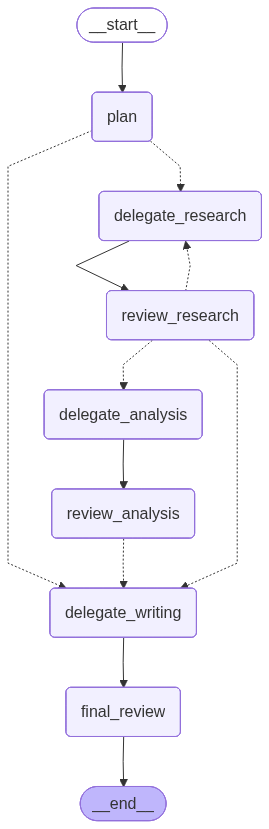

In [7]:
# Visualize the Manager Agent's orchestration graph
display(
    Image(
        manager_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run examples
Let's test with different types of questions to see dynamic routing and intelligent coordination in action. We will test:
- A simple question (should skip research/analysis)
- A moderate question (needs research)
- A complex question (needs research AND analysis)

In [8]:
def run_example(question: str):
    """Helper function to run and display results."""
    print("=" * 80)
    print(f"QUESTION: {question}")
    print("=" * 80)
    
    initial_state = ManagerAgentState(
        messages=[HumanMessage(content=question)],
        user_question=question,
        task_complexity="",
        delegation_plan={},
        research_findings="",
        research_quality="",
        research_retry_count=0,
        analysis_insights="",
        analysis_quality="",
        final_answer="",
        final_quality="",
        current_step="",
        errors=[]
    )
    
    result = manager_agent.invoke(initial_state)
    
    print(f"\n📋 TASK COMPLEXITY: {result.get('task_complexity', 'unknown')}")
    print(f"📊 DELEGATION PLAN: {result.get('delegation_plan', {})}")
    
    if result.get('research_findings'):
        print(f"\n🔍 RESEARCH (Quality: {result.get('research_quality', 'N/A')}):")
        findings_preview = result['research_findings'][:300]
        print(findings_preview + ("..." if len(result['research_findings']) > 300 else ""))
    
    if result.get('analysis_insights'):
        print(f"\n📈 ANALYSIS (Quality: {result.get('analysis_quality', 'N/A')}):")
        insights_preview = result['analysis_insights'][:300]
        print(insights_preview + ("..." if len(result['analysis_insights']) > 300 else ""))
    
    print(f"\n✍️ FINAL ANSWER (Quality: {result.get('final_quality', 'N/A')}):")
    print(result['final_answer'])
    
    if result.get('errors'):
        print(f"\n⚠️ ERRORS: {result['errors']}")
    
    print("\n" + "=" * 80 + "\n")

#### Example 1: Simple question (Should skip research/analysis)

In [9]:
run_example("What is 2 + 2?")

QUESTION: What is 2 + 2?

📋 TASK COMPLEXITY: simple
📊 DELEGATION PLAN: {'complexity': 'simple', 'needs_research': False, 'needs_analysis': False, 'reasoning': 'The question is a direct mathematical query that requires a straightforward answer. It does not require any research or analysis, making it a simple task suitable for the Writer Agent only.'}

✍️ FINAL ANSWER (Quality: sufficient):
The question "What is 2 + 2?" is a straightforward mathematical inquiry that involves basic arithmetic. To solve this, we simply add the two numbers together.

1. **Understanding the Numbers**: 
   - The number 2 represents a quantity or value.
   - The plus sign (+) indicates that we are to combine or add the two quantities.

2. **Performing the Addition**:
   - When we add 2 and 2, we are essentially counting two units and then adding another two units to that count.
   - This can be visualized as follows:
     - Start with 2: ●●
     - Add another 2: ●●
     - When combined, we have: ●●●●

3. **Cal

#### Example 2: Moderate question (Needs research)

In [10]:
run_example("What is the difference between supervised and unsupervised learning?")

QUESTION: What is the difference between supervised and unsupervised learning?

📋 TASK COMPLEXITY: moderate
📊 DELEGATION PLAN: {'complexity': 'moderate', 'needs_research': True, 'needs_analysis': False, 'reasoning': 'The question requires a factual explanation of the differences between supervised and unsupervised learning, which necessitates some research to gather accurate definitions and examples. However, it does not require data analysis or interpretation, making it moderate in complexity.'}

🔍 RESEARCH (Quality: sufficient):
### Difference Between Supervised and Unsupervised Learning

**1. Definition:**
   - **Supervised Learning:** This is a type of machine learning where the model is trained on a labeled dataset. Each training example is paired with an output label, allowing the model to learn the relationship between...

✍️ FINAL ANSWER (Quality: sufficient):
### Difference Between Supervised and Unsupervised Learning

Machine learning is a powerful subset of artificial intell

#### Example 3: Complex question (Needs research AND analysis)

In [11]:
run_example("What are the main causes of deforestation in the Amazon rainforest and what can be done to address them?")

QUESTION: What are the main causes of deforestation in the Amazon rainforest and what can be done to address them?

📋 TASK COMPLEXITY: complex
📊 DELEGATION PLAN: {'complexity': 'complex', 'needs_research': True, 'needs_analysis': True, 'reasoning': 'The question requires gathering factual information about the causes of deforestation in the Amazon rainforest, which involves research. Additionally, it requires interpreting that data to extract insights on potential solutions, which involves analysis. Therefore, both research and analysis are needed, along with a polished response.'}

🔍 RESEARCH (Quality: insufficient):
### Main Causes of Deforestation in the Amazon Rainforest

1. **Agricultural Expansion**:
   - **Cattle Ranching**: The primary driver of deforestation, with large areas of forest cleared for pastureland.
   - **Soybean Cultivation**: Significant portions of the Amazon are cleared for soybean farmin...

✍️ FINAL ANSWER (Quality: sufficient):
### Main Causes of Deforestati

In this example, we see true multi-agent collaboration:

1. **Manager agent** receives the question and creates a delegation plan.
2. **Research agent** (independent agent) is invoked to gather information about Amazon deforestation.
3. **Analysis agent** (independent agent) is invoked to analyze the research findings.
4. **Writer agent** (independent agent) is invoked to synthesize everything into a polished response.

This demonstrates the hierarchical pattern's power: a manager coordinates multiple specialized workers with intelligence, not just mechanical delegation. The system adapts to task complexity, ensures quality through review gates, handles errors gracefully, and optimizes resource usage.